In [ ]:
!pip install tensorflow

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

In [3]:
assert 'COLAB_TPU_ADDR' in os.environ, 'Missin TPU?'
if('COLAB_TPU_ADDR') in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER = ''
tpu_address = TF_MASTER

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [5]:
strategy = tf.distribute.TPUStrategy(resolver)

In [6]:
def create_model():
  return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')# всего пять классов цветов
        
  ])

In [7]:
def get_train_and_val_dataset(batch_size, is_training=True):
    if(is_training):
        dataset, info = tfds.load(name='tf_flowers',
                                  split='train[:80%]', 
                                  with_info = True,
                                  as_supervised=True,
                                  try_gcs=True)
    else:
        dataset, info = tfds.load(name='tf_flowers',
                                  split='train[80%:90%]', 
                                  with_info = True,
                                  as_supervised=True,
                                  try_gcs=True)
    
    def scale(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, [224, 224]) # изменение всех изображений на вход до (None, 224, 224)
        image /= 255.0 # Нормализация
        return image, label
    
    dataset = dataset.map(scale)
    
    if is_training:
        dataset = dataset.shuffle(2936)#Перемешивание обучающей выборки
        dataset = dataset.repeat()
        
    dataset = dataset.batch(batch_size)
    return dataset


In [8]:
def get_final_dataset(batch_size):
    dataset, info = tfds.load(name='tf_flowers',
                                  split='train[90%:]', 
                                  with_info = True,
                                  as_supervised=True,
                                  try_gcs=True)
    def scale(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, [224, 224]) # изменение всех изображений на вход до (None, 224, 224)
        image /= 255.0 # Нормализация
        return image, label  
    dataset = dataset.map(scale)
    
    #dataset = dataset.shuffle(2936)#Перемешивание обучающей выборки
    #dataset = dataset.repeat()
        
    dataset = dataset.batch(batch_size)
    return dataset


In [10]:
def create_xception_model(input_shape=(224, 224, 3), num_classes=5):
    #Загрузка предварительно обученной модели Xception без головной части
    base_model = tf.keras.applications.Xception(include_top=False, input_shape=input_shape)

    #Добавление головной части
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    #Объединение предварительно обученной модели и головной части в единую модель
    model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

    #Заморозка слоев предварительно обученной модели
    for layer in base_model.layers:
        layer.trainable = False

    return model


In [43]:
batch_size = 1024 #Размер пакета
epochs = 1000 #Количество эпох, на тензорных процессорах можно делать много проверок
execution_steps = 1000 #Количество шагов перед обновлением весов
#Загрузка и создание обучающей и проверочной(валидационной) выборки
train_dataset = get_train_and_val_dataset(batch_size, True)
validation_dataset = get_train_and_val_dataset(batch_size, False)
steps_per_epoch = 2936 // batch_size
validation_steps = len(validation_dataset) // batch_size


In [44]:
with strategy.scope():
    xmodel = create_xception_model()
    xmodel.compile(optimizer='adagrad', steps_per_execution=execution_steps, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['sparse_categorical_accuracy'])
    x_history = xmodel.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset)


Epoch 1/1000
2/2 [==============================] - 33s 16s/step - loss: 1.6967 - sparse_categorical_accuracy: 0.1914 - val_loss: 1.6057 - val_sparse_categorical_accuracy: 0.2016
Epoch 2/1000
2/2 [==============================] - 2s 1s/step - loss: 1.6826 - sparse_categorical_accuracy: 0.2134 - val_loss: 1.5786 - val_sparse_categorical_accuracy: 0.2371
Epoch 3/1000
2/2 [==============================] - 3s 2s/step - loss: 1.6400 - sparse_categorical_accuracy: 0.2217 - val_loss: 1.5564 - val_sparse_categorical_accuracy: 0.2670
Epoch 4/1000
2/2 [==============================] - 2s 1s/step - loss: 1.6230 - sparse_categorical_accuracy: 0.2427 - val_loss: 1.5328 - val_sparse_categorical_accuracy: 0.3025
Epoch 5/1000
2/2 [==============================] - 2s 1s/step - loss: 1.5863 - sparse_categorical_accuracy: 0.2681 - val_loss: 1.5112 - val_sparse_categorical_accuracy: 0.3379
Epoch 6/1000
2/2 [==============================] - 2s 1s/step - loss: 1.5787 - sparse_categorical_accuracy: 0.27

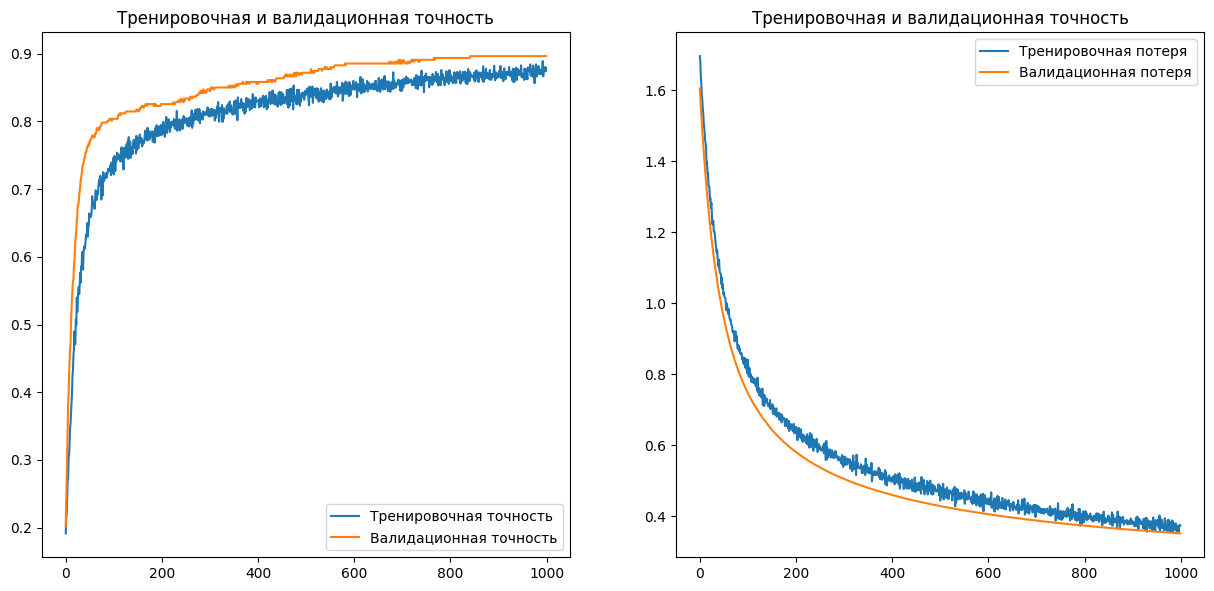

In [45]:
#Переменные для графика
acc = x_history.history['sparse_categorical_accuracy']
val_acc = x_history.history['val_sparse_categorical_accuracy']
loss = x_history.history['loss']
val_loss = x_history.history['val_loss']
epochs_range = range(epochs)


#График при помощи matplotlib
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Тренировочная точность')
plt.plot(epochs_range, val_acc, label='Валидационная точность')
plt.legend(loc='lower right')
plt.title('Тренировочная и валидационная точность')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Тренировочная потеря')
plt.plot(epochs_range, val_loss, label='Валидационная потеря')
plt.legend(loc='upper right')
plt.title('Тренировочная и валидационная точность')
plt.show()


In [ ]:
#print(history.history.keys())

In [46]:
#всего три выборки: тренировочная(train_dataset), валидационная(validation_dataset) и тестовая(test_dataset)
#тренировочная 0:80 
#валидационная 80:90
#тестовая 90:100
test_dataset = get_final_dataset(batch_size)
test_images, test_labels = next(iter(test_dataset.take(10)))
#Можно использоать информацию о классах из info, но мне нужно было перевести названия классов и их не слишком много, поэтому я решил их инициализировать. Если количество классов большое, например их 100 или больше, то лучше обращаться к ним через info.
class_names = ['Одуванчик', 'Ромашка', 'Тюльпаны', 'Подсолнухи', 'Розы']

In [50]:
test_loss, test_accuracy = xmodel.evaluate(test_dataset)
print('Test loss: {}, Test accuracy: {}'.format(test_loss, test_accuracy))

1/1 [==============================] - 2s 2s/step - loss: 0.3759 - sparse_categorical_accuracy: 0.8719
Test loss: 0.37588292360305786, Test accuracy: 0.8719345927238464


12/12 [==============================] - 1s 93ms/step


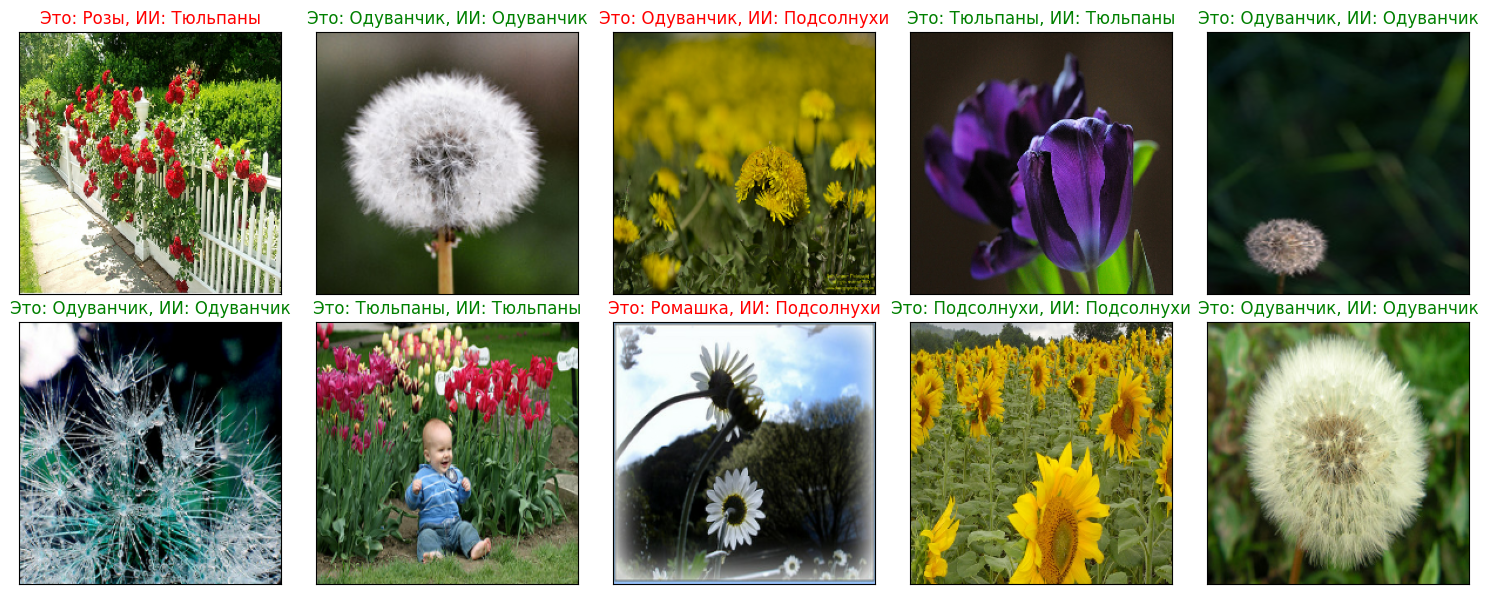

In [51]:
# Получение предсказаний нейросети для 10 изображений
predictions = xmodel.predict(test_images)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    # Отображение изображения
    ax.imshow(test_images[i])
    # Отображение меток и предсказаний
    true_label = class_names[test_labels[i]]
    pred_label = class_names[np.argmax(predictions[i])]
    if true_label == pred_label:
        ax.set_title("Это: {}, ИИ: {}".format(true_label, pred_label), color='green')
    else:
        ax.set_title("Это: {}, ИИ: {}".format(true_label, pred_label), color='red')

plt.tight_layout()
plt.show()